## GMARKET 크롤링하기
### 1. 크롤러(spider)로 데이터 추출/출력해보기

사이트: http://corners.gmarket.co.kr/Bestsellers #지마켓 베스트상품 크롤링

* 앞서 연습할 때 만들었던 ecommerce폴더는 삭제 (파일 탐색기에서 삭제 가능)
* scrapy 다시 실행, project 만들기

In [ ]:
scrapy startproject ecommerce
cd ecommerce
cd ecommerce
scrapy genspider gmarket_best corners.gmarket.co.kr/Bestsellers

* Sublime Text3 실행, ~/gmarket_berst.py파일 코드 수정
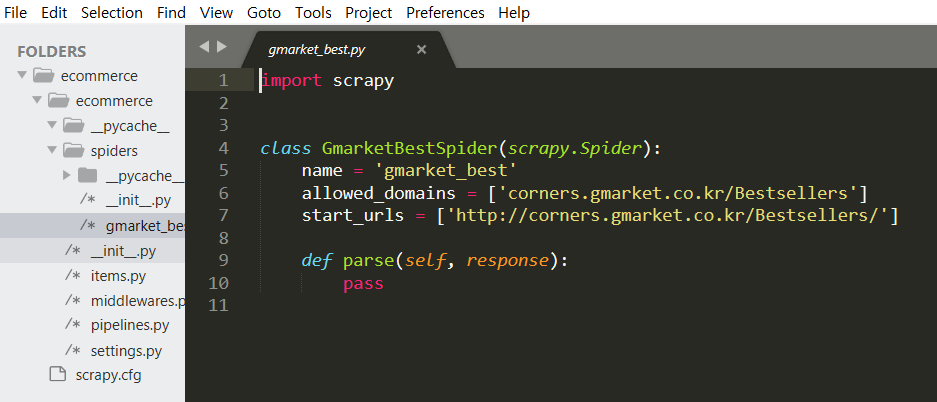

* 코드 고치기 전, response함수에 더해 re()로 정규표현식 쓰는 법 익히기 

In [ ]:
#주소를 작은 따옴표 안에 썼을 때 에러가 나는 경우, 큰따옴표로 바꾸기
scrapy shell "http://corners.gmarket.co.kr/Bestsellers"
#베스트 상품의 타이틀 텍스트로 출력하기
response.css('div.best-list li > a::text').getall()
response.xpath('//div[@class="best-list"]/ul/li/a/text()').getall()
               
#텍스트 출력 결과를 문장이 아닌 키워드별로 추출하고 싶을 때: re('(\w+)')추가로 쓰기
response.css('div.best-list li > a::text')[1].re('(\w+)')
response.xpath('//div[@class="best-list"]/ul/li/a/text()')[1].re('(\w+)')

exit #shell 끝내기

* Sublime Text3로 돌아가서, 맨 마지막 줄 pass 지우고, response함수 사용해서 코드 고치기

In [ ]:
#베스트 상품 가져오고, 제대로 가져와진건지 확인하기 위해 출력해보기
titles = response.css('div.best-list li > a::text').getall()
for title in titles:
print (title)

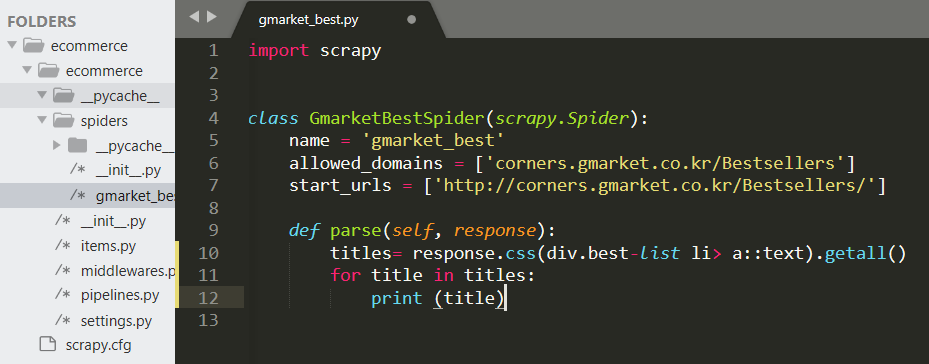

* 코드 저장 후, 프롬프트로 돌아가서 실행

In [ ]:
scrapy crawl gmarket_best

### 2. 크롤러(spider)로 데이터 저장하기
**1) items.py 작성** <br>
items.py의 pass코드를 지우고 그 자리에 어떤 아이템을 데이터로 가져올지를 선언

In [ ]:
title=scrapy.Field() #자신이 쓸 아이템의 이름을 정해 필드 선언 후 저장

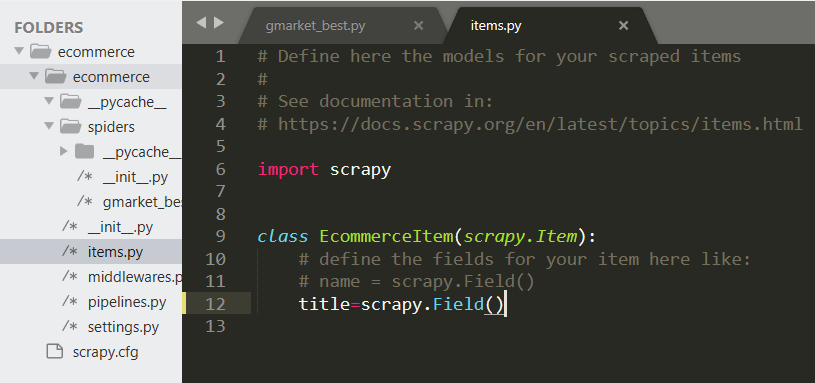

**2) 앞서 작성한 py파일 다시 작성(gmarket_best):** <br>
items에서 선언한 아이템을 gmarket_best에서 items로 전달해주도록 수정(선언한 "title"을 두 코드파일에서 연결시켜 줘야 한다)  
<br>
import scrapy 코드 밑에 아래 코드 추가: eccommerce안에 있는 파이썬코드들 중 items라는 코드를 가져올 것이며, 그 중 EcommerceItem이라는 클래스를 gmarket_best라는 별도의 코드파일로 가져와 쓰겠다. 

In [ ]:
from ecommerce.items import EcommerceItem

for문 밑에 코드들 지우고, 아래 코드 추가

In [ ]:
#클래스를 별도의 이름으로 선언하여 객체 생성
item= EcommerceItem() 

In [ ]:
#클래스 안의 title이라는 변수에 parsing해서 가져올 데이터를 계속 넣어준다
item['title'] = title

In [ ]:
#데이터를 계속 넣어줄 때마다, items.py파일로 데이터가 넘어가 쌓인다.
yield title

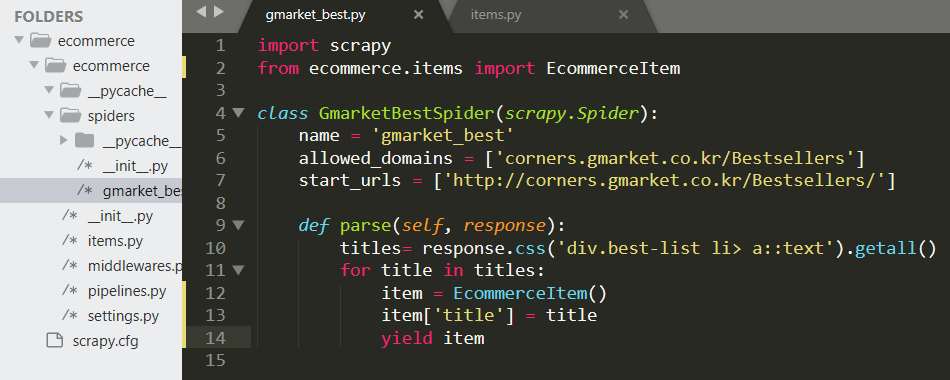

정리: gmarket. best에서 yield 명령어로 아이템(item)에 저장할 수 있다.
* 선언: from 프로젝트이름.items import 아이템클래스명
* 클래스 생성: item = 아이템클래스명()
* 아이템 저장
 * item['아이템명'] = 아이템데이터
 * yield item

### 3. 크롤러(spider)로 데이터 처리하기 (scrapy의 강점)

* 다양한 데이터 포맷으로 아이템 저장하기
 * csv, xml, json 포맷
 * 터미널 환경에서, cd ecommerce 후 다음 형식으로 명령 실행  
  : scrapy crawl 크롤러명 -o 저장할파일명 -t 저장포멧

In [ ]:
# 예
scrapy crawl gmarket_best -o gmarket.csv -t csv
scrapy crawl gmarket_best -o gmarket.xml -t xml

* csv 한글깨짐 해결: csv파일 오른쪽클릭 >연결 프로그램> 메모장> 다른 이름으로 저장> 파일 이름에 .csv 붙이고, 파일 형식으로'모든 파일'선택, 인코딩 방식 ANSI 선택
* json 한글깨짐 문제 해결 위한 추가 작업: settings.py수정 (아래)


In [ ]:
FEED_EXPORT_ENCODING = 'utf-8' #유니코드 문제는 항상 존재. utf-8만 기억해놓으면 됨

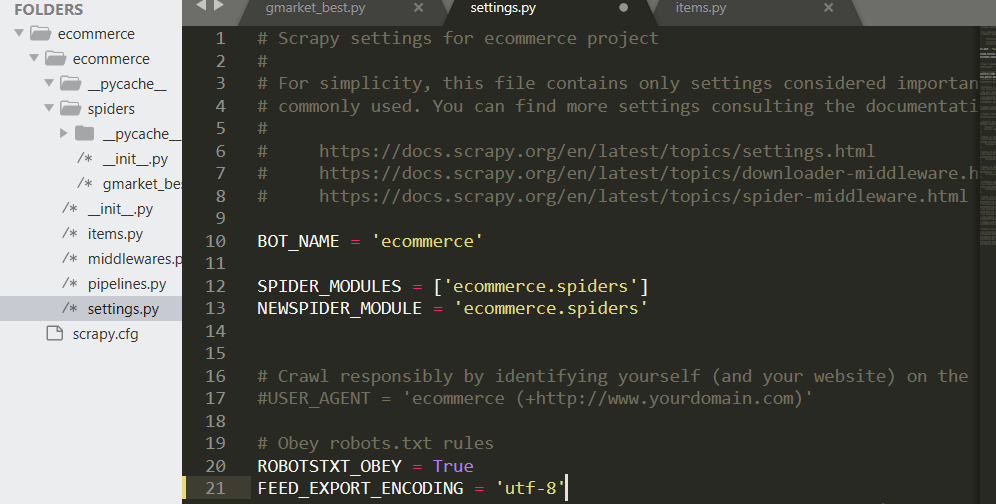

In [ ]:
scrapy crawl gmarket_best -o gmarket.json -t json

### 4. 크롤러(spider)로 아이템 데이터 후처리하기 (scrapy의 강점)
: pipelines.py 파일을 수정하여 후처리
* 일부 아이템은 저장하지 않거나,
* 중복되는 아이템을 저장하지 않거나,
* 데이터베이스등에 저장하거나,
* 특별한 포멧으로 아이템을 저장하고 싶거나<br>
<br>
ex) 만원 이상인 상품의 이름과 가격만을 가져오고 싶을 때?

1) 기존 코드를 상품과 가격을 모두 가져오는 방향으로 수정<br>
1-1) items.py 에 아래 코드 추가

In [ ]:
price=scrapy.Field()

1-2) gmartet_best.py 수정<br>
* parse 함수에서 for문 전에 prices라는 변수 만들기, response.css()안에 있는 코드 수정+작성

In [ ]:
titles= response.css('div.best-list ul> li > a::text')[:200].getall()
        prices= response.css('div.best-list ul> li > div.item_price > div.s-price > strong > span > span::text')[:200].getall()
#ul > li : ul tag 바로 밑에(하위에) 있는 li태그 중 id가 있는 것들만.
#best상품 외에도, 페이지 하단에 있는 광고 상품도 크롤링이 되는 문제를 해결하기 위해 구체적으로 지정

* for문 수정

In [ ]:
#enumerate: 순서가 있는 자료형을 입력받아 인덱스값에 포함시키는 역할. for문 안에서는 값 1개당 1번 반복하도록 
#strip(): 문자열 앞뒤의 space(띄어쓰기)를 제거
#replace("원",""): ~원 이라고 써있는 price값에서 '원'글자를 제거하기 위한 함수 
for num, title in enumerate(titles):
        item = EcommerceItem()
        item['title'] = title
        item['price'] = prices[num].strip().replace("원","").replace(",","")
        yield item

In [ ]:
scrapy crawl gmarket_best #터미널에 돌려서 확인

2) settings.py 수정  
: ITEM)PIPELINES 주석처리 해제
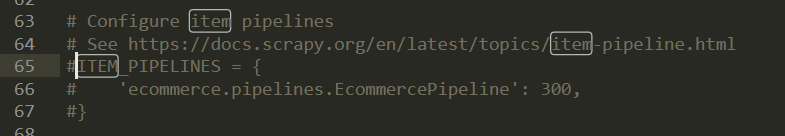

: 여러 클래스가 있을 경우, 숫자가 낮을수록 먼저 실행됨. 일종의 우선순위 번호.  
0~1000 숫자 중 임의로 숫자를 부여하면 됨 (지금은 크롤링을 한 개만 하고 있으니 의미 없음)

3) pipeline.py의 process_item 함수 수정  
각 아이템 생성시, pipeline.py 에 있는 process_item 함수를 거쳐가게 되어 있음  
필요한 아이템만 return 해주고, 필터링할 아이템은 DropItem 을 통해, 더이상의 아이템처리를 멈추게 해줘야 함


In [ ]:
from scrapy.exceptions import DropItem

class NavernewsPipeline(object):
    def process_item(self, item, spider):
        print (item)
        if item['price'] > 10000: #가격이 만원 이상인 아이템만 크롤링
            return item
        else:
            raise DropItem("drop item having lower price than 10000") #if 조건에 해당이 안 되는 아이템은 저장이 안되고 사라져버림

In [ ]:
scrapy crawl gmarket_best #터미널에 돌려서 확인

4) 결과를 파일로 저장해보기

In [ ]:
scrapy crawl gmarket_best -o gmarket_product.csv -t csv #터미널:원래 데이터는 200개인데 그 중 153개만 저장된 것 확인 가능